# Extract 2D Area Cells from HEC-RAS .HDF files for all plans in a directory

Created on Wed Aug 19 13:47:47 2015
@author: mwarms

This code can be used to extract data from HEC-RAS 2D area cells of interest for all plans--specifically the maximum water surface. Useful when there are numerous plans--in this case an incremental hazard analysis was performed, so ~50 plans were run overnight. 

In [83]:
import pandas as ps # useful databases/arrays for storing data
import h5py         # read HEC-RAS HDF files (pandas HDFStore does not work)           
import os as os     # windows operating system  
import numpy as np  # useful for plotting, scientific analysis, etc. 
import matplotlib.pyplot as plt #plotting
import seaborn as sns
sns.set()

In [84]:
# initialize data frame in which to store data (in this case we want maximum WSE and time):
MaxWSE = ps.DataFrame()
#MaxWSEtime = ps.DataFrame()  # <-- this is unnecessary if you do not want the time at which the peak occurs

In [85]:
# initialize path variable:
path = "C:\users\mwarms\documents\USSDConference2016\RAS HDFs"


In [86]:
# initialize HDFkey (i.e. path to desired variable in HDF file):
    # to determine the key, you can either view the HDF manually or open the HDF
    # using h5py (see below) and use the h5py.keys() function (e.g. f_temp.keys())

example_h5py_file = h5py.File(path + "\NineMileDamBreach.p01.hdf")
example_h5py_file.keys()

[u'Event Conditions', u'Geometry', u'Plan Data', u'Results']

In [87]:
example_h5py_file['Results'].keys()

[u'Summary', u'Unsteady']

In [88]:
example_h5py_file['Results/Unsteady'].keys()

[u'Geometry Info', u'Output', u'Summary']

In [89]:
# continue this logic until you reach the key that you want. Again, this can be done in python or viewing the HDF file manually.

HDFkey = '/Results/Unsteady/Output/Output Blocks/Base Output/Summary Output/2D Flow Areas/Long Lake & L.S./Maximum Water Surface'

In [90]:
# initialize HEC-RAS project name:
HECRASProject = "NineMileDamBreach"

In [91]:
# initialize total number of 2D area cells (array 0 = max wse data, 1 = time which max occurs), both will be the same size: 
TotNumCells = example_h5py_file[HDFkey][0].size
example_h5py_file.close()
TotNumCells

8912

In [92]:
# Loop through HDF plan files and extract Max WSE for all cells
os.chdir(path)  # <--necessary when your ipynb is not in the same folder as the data you care about

i = 0
for file in os.listdir(path):
    if file.endswith(".hdf") and file.startswith(HECRASProject + ".p"):
        f_temp = h5py.File(file)
        d_temp = f_temp[HDFkey][:]    
        MaxWSE[i] = ps.Series(d_temp[0,0:TotNumCells])
        #MaxWSEtime[i] = ps.Series(d_temp[1,0:TotNumCells]) # <-- this is unnecessary if you do not want the time at which the peak occurs
        i+=1 

In [93]:
# initialize variable for total number of plans
TotalPlans = i
TotalPlans

59

In [94]:
# Which cells do we care about in the 2D Area? (Upstream to Downstream)
SelectedCells = [5036,3996,3695,3421,3260,2923,2485,2056,1542,930,855,784,
                 590,366,313,403,448,614,943,1480,1990,2086,1976,1870,1555] 

In [95]:
# HEC-RAS plan numbers belonging to each geometry (13 excluded--not used)
#    Note: This is only necessary if you have multiple geometries 
#    Normally, you could use this line:
#    Plans = range(1,TotalPlans+1)
HighScourPlans = sorted([16,2,5,4,9,8,6,12,11,10,15,14])
MedScourPlans = sorted([17,3,18,20,22,24,26,28,30,32,34,36])
LowScourPlans = sorted([1,7,19,21,23,25,27,29,31,33,35,37])
IHAPlans = [13,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59]


In [96]:
# Query MaxWSE data to extract just the cells we are interested in. Again, 
#    since we have 3 different geometries, the selected cells change depending
#    on the plan
CellsMaxWSEHighScour = ps.DataFrame()  # initialize data frame in which to store data
CellsMaxWSEMedScour = ps.DataFrame()   # initialize data frame in which to store data
CellsMaxWSELowScour = ps.DataFrame()   # initialize data frame in which to store data
CellsMaxWSEIHA = ps.DataFrame()        # initialize data frame in which to store data

In [97]:
# Loop through plans to populate the different dataframes (mult. by 24 to convert to hours)
for j in range(1,TotalPlans+1):
    if j in HighScourPlans:
        CellsMaxWSEHighScour[0,j] = MaxWSE[j-1].iloc[SelectedCells[:]]
        #CellsMaxWSEHighScour[1,j] = MaxWSEtime[j-1].iloc[SelectedCells[:]]*24 # <-- this is unnecessary if you do not want the time at which the peak occurs
    elif j in MedScourPlans:
        CellsMaxWSEMedScour[0,j] = MaxWSE[j-1].iloc[SelectedCells[:]]
        #CellsMaxWSEMedScour[1,j] = MaxWSEtime[j-1].iloc[SelectedCells[:]]*24 # <-- this is unnecessary if you do not want the time at which the peak occurs
    elif j in LowScourPlans:
        CellsMaxWSELowScour[0,j] = MaxWSE[j-1].iloc[SelectedCells[:]]
        #CellsMaxWSELowScour[1,j] = MaxWSEtime[j-1].iloc[SelectedCells[:]]*24 # <-- this is unnecessary if you do not want the time at which the peak occurs
    elif j in IHAPlans:
        CellsMaxWSEIHA[0,j] = MaxWSE[j-1].iloc[SelectedCells[:]]
        #CellsMaxWSEIHA[1,j] = MaxWSEtime[j-1].iloc[SelectedCells[:]]*24 # <-- this is unnecessary if you do not want the time at which the peak occurs

In [98]:
# Write Extracted output to excel spreadsheet or csv:
  # Excel example  below:   
      #    writer = ps.ExcelWriter('IncrementalHazardAnalysis.xlsx')
      #    CellsMaxWSEHighScour.to_excel(writer,'HighScourPlans')
      #    CellsMaxWSEMedScour.to_excel(writer,'MedScourPlans')
      #    CellsMaxWSELowScour.to_excel(writer,'LowScourPlans')
      #    writer.save()
  # CSV example below:
      #   CellsMaxWSEHighScour.to_csv('HighScour.csv', sep=',')
      #   CellsMaxWSEMedScour.to_csv('MedScour.csv', sep=',')
      #   CellsMaxWSELowScour.to_csv('LowScour.csv', sep=',')
      #   CellsMaxWSEIHA.to_csv('IHA.csv', sep=',')

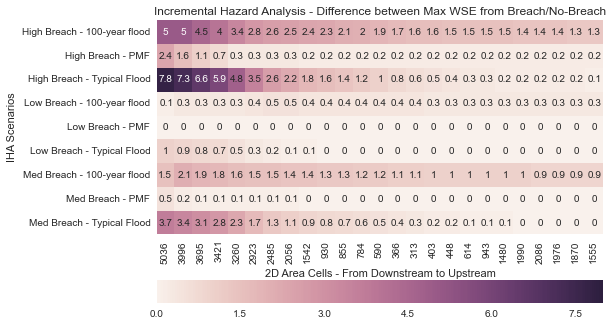

In [161]:
# Create Incremental Hazard Analysis DataFrame (for Med Scour) -- Need to know which plans involve breach and which plans don't:
# No Breach Plans: 17 = typical flood, 3 = 100-year flood, 18 = PMF
# Low Breach Plans: 20 = typical flood, 22 = 100-year flood, 24 = PMF
# Med Breach Plans: 26 = typical flood, 28 = 100-year flood, 30 = PMF
# High Breach Plans: 32 = typical flood, 34 = 100-year flood, 36 = PMF

IHA = ps.DataFrame({'Low Breach - Typical Flood':CellsMaxWSEMedScour[0,20] - CellsMaxWSEMedScour[0,17],
                    'Low Breach - 100-year flood':CellsMaxWSEMedScour[0,22] - CellsMaxWSEMedScour[0,3],
                    'Low Breach - PMF':CellsMaxWSEMedScour[0,24] - CellsMaxWSEMedScour[0,18],
                    'Med Breach - Typical Flood':CellsMaxWSEMedScour[0,26] - CellsMaxWSEMedScour[0,17],
                    'Med Breach - 100-year flood':CellsMaxWSEMedScour[0,28] - CellsMaxWSEMedScour[0,3],
                    'Med Breach - PMF':CellsMaxWSEMedScour[0,30] - CellsMaxWSEMedScour[0,18],
                    'High Breach - Typical Flood':CellsMaxWSEMedScour[0,32] - CellsMaxWSEMedScour[0,17],
                    'High Breach - 100-year flood':CellsMaxWSEMedScour[0,34] - CellsMaxWSEMedScour[0,3],
                    'High Breach - PMF':CellsMaxWSEMedScour[0,36] - CellsMaxWSEMedScour[0,18]}).transpose()

sns.heatmap(np.round(IHA, decimals=1), vmin=0, vmax = 8, annot=True, cbar_kws={"orientation": "horizontal"})
title('Incremental Hazard Analysis - Difference between Max WSE from Breach/No-Breach')
xlabel('2D Area Cells - From Downstream to Upstream')
ylabel('IHA Scenarios')